# ***Probamos modelo VGG16***

**Inicialmente cargamos librerias**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image

**Cargamos las rutas que contienen los datos**

In [5]:
train_path = "/kaggle/input/skin-burn-dataset/skin burn dataset/train/"
test_path = "/kaggle/input/skin-burn-dataset/skin burn dataset/test"
val_path = "/kaggle/input/skin-burn-dataset/skin burn dataset/valid/"

In [3]:
if torch.cuda.is_available():
    print(f"GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No se detectaron GPUs")

GPUs disponibles: 1
GPU 0: Tesla P100-PCIE-16GB


**Procedemos a aplicar transformaciones a los datos de entrada**

In [16]:
class_ = {'1st degree burn': 0, '2nd degree burn': 1 , '3nd degree burn': 2}

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize(256),  # Cambiamos el tamaño al valor más pequeño, puede ser ancho o alto
    transforms.CenterCrop(224),  # Ahora recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización basada en las estadísticas
])


# En las transformaciones de validación quitamos las alteraciones aleatorias
val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.Resize(256),  # Cambiamos el tamaño al valor más pequeño
    transforms.CenterCrop(224),  # Recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

# Crear los dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=4,  # Añadido para mejor rendimiento
    pin_memory=True  # Añadido para mejor rendimiento con GPU
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False,
    num_workers=4,  # Añadido para mejor rendimiento
    pin_memory=True  # Añadido para mejor rendimiento con GPU
)

In [13]:
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)

['1st degree burn', '2nd degree burn', '3nd degree burn']
['1st degree burn', '2nd degree burn', '3nd degree burn']


***Declaramos variables para almacenar los datos obtenidos por cada epoca***

In [17]:
# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 50
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo VGG16 pre-entrenado
vgg16 = models.vgg16(pretrained=True)

# Obtener el número correcto de características de entrada
num_ftrs = 512 * 7 * 7  # Este es el número típico para VGG16 con entrada 224x224

#probar nuevamente con el modelo fuera del for que contiene los folds
vgg16.classifier = nn.Sequential(
   nn.Linear(num_ftrs, 1024),
   nn.ReLU(),
   nn.Dropout(0.7),
   nn.Linear(1024, 512),
   nn.ReLU(),
   nn.Dropout(0.7),
   nn.Linear(512, num_classes)
)

vgg16 = vgg16.to(device)

# Descongelar más capas
for param in vgg16.features[-4:].parameters():  # Últimas 4 capas convolucionales
    param.requires_grad = True

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Ajustar los hiperparámetros
learning_rate = 0.00001  # Learning rate más bajo
weight_decay = 1e-3 # Regularización con Weight Decay

train_labels = [label for _, label in train_dataset]

# Configurar la matriz de confusión
unique_classes = np.unique(train_labels)
conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))

# Definir optimizador y función de pérdida
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Puedes ajustar el learning rate según tu caso
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Para clasificación multiclase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    best_accuracy = 0.0
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=64, 
        sampler=train_subsampler,
        num_workers=4  # Ajusta según tu CPU
    )
    
    val_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=64, 
        sampler=val_subsampler,
        num_workers=4  # Ajusta según tu CPU
    )
            
    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
    
        train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(all_preds_train) == np.array(all_labels_train))
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        
        # Validación y cálculo de matriz de confusión
        vgg16.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        scheduler.step(val_loss)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(vgg16.state_dict(), 'vgg16_entrenadoMobileApp.pt')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1/5
Epoch [1/50], Training Loss: 1.0745, Validation Loss: 0.9927, Training Accuracy: 0.3884, Validation Accuracy: 0.5373, Training F1 Score: 0.3840, Validation F1 Score: 0.5151
Modelo mejorado, guardado.
Epoch [2/50], Training Loss: 0.8905, Validation Loss: 0.7535, Training Accuracy: 0.5418, Validation Accuracy: 0.6091, Training F1 Score: 0.5338, Validation F1 Score: 0.5987
Modelo mejorado, guardado.
Epoch [3/50], Training Loss: 0.7825, Validation Loss: 0.7402, Training Accuracy: 0.6166, Validation Accuracy: 0.6173, Training F1 Score: 0.6140, Validation F1 Score: 0.6114
Modelo mejorado, guardado.
Epoch [4/50], Training Loss: 0.7218, Validation Loss: 0.6934, Training Accuracy: 0.6400, Validation Accuracy: 0.6500, Training F1 Score: 0.6393, Validation F1 Score: 0.6455
Modelo mejorado, guardado.
Epoch [5/50], Training Loss: 0.6818, Validation Loss: 0.6820, Training Accuracy: 0.6709, Validation Accuracy: 0.6864, Training F1 Score: 0.6718, Validation F1 Score: 0.6768
Modelo mejorado, g

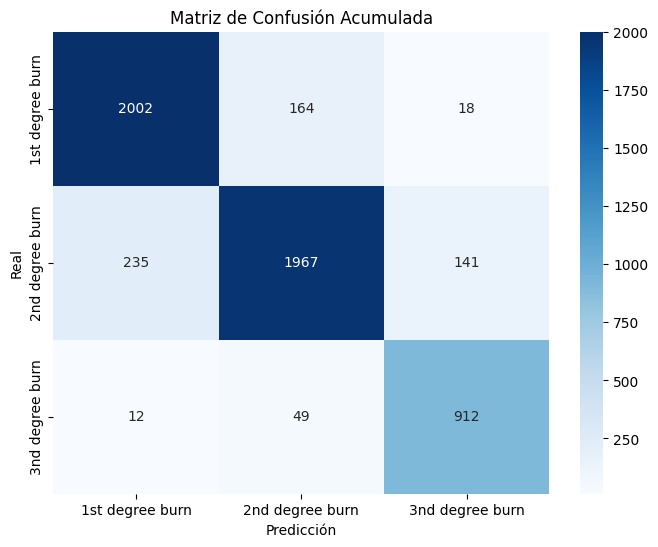

In [18]:
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

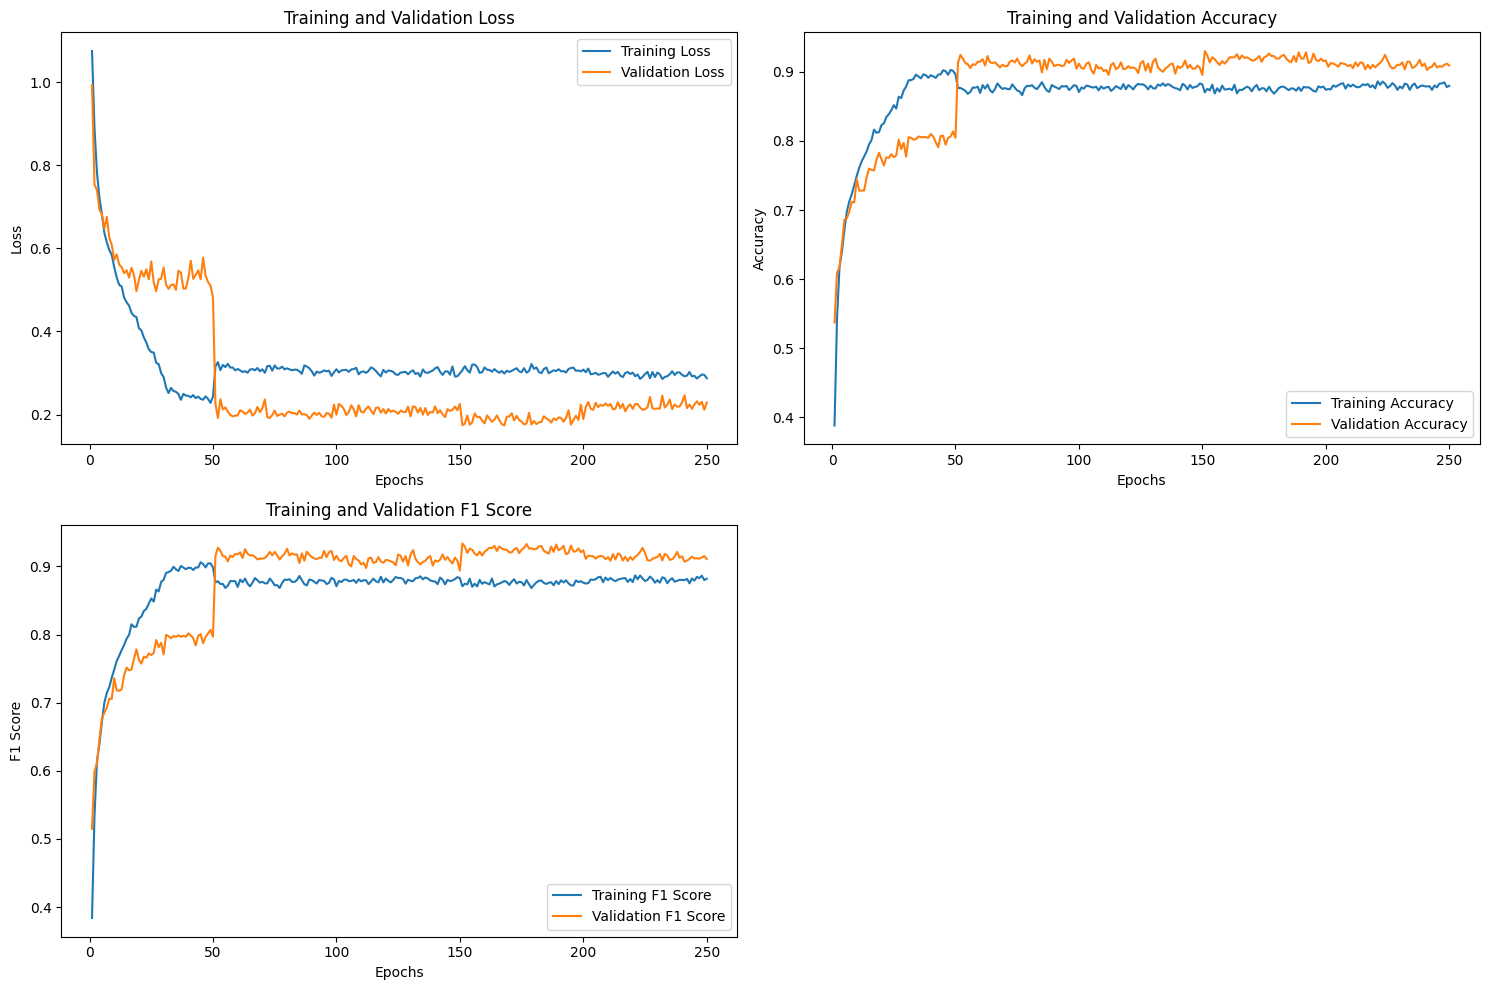

In [19]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()